# Brand Identity Tool
This notebook wires three different systems into a single identity pipeline that helps transform creative ideas into production-ready brand assets. The pipeline is therefore organized as follows:
- **System A: Identity Definer (LLM)** creates an identity manifest from a vague concept.
- **System B: Visual Generator (Diffusion + Adapters)** renders images from the generated manifest.
- **System C: Quality Critic (VLM)** measures visual drift by comparing to what extent outcomes align with the manifest.

Please be welcome to use this notebook to run tests, then save manifests, prompts, images, and scores. Enjoy!

## 1. Project Environment (One-Time Setup)
These cells create a local `.venv`, install minimal packages, and register a Jupyter kernel.


In [1]:
# # create the project venv (one-time)
! python -m venv .venv

Error: [Errno 13] Permission denied: 'c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\code\\.venv\\Scripts\\python.exe'


In [2]:
# # install packages for the notebook (full set)
# ! .\.venv\Scripts\python -m pip install -r requirements.txt

# install packages for the notebook (minimal set)
! .\.venv\Scripts\python -m pip install -r requirements_min.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# register the kernel
! .\.venv\Scripts\python -m ipykernel install --user --name genai-brand --display-name "GenAI Brand"

Installed kernelspec genai-brand in C:\Users\pavel\AppData\Roaming\jupyter\kernels\genai-brand


In [4]:
# verify the venv path (note: this does not change the active kernel)
! .\.venv\Scripts\python -c "import sys; print(sys.executable)"

import sys
print("Kernel Python:", sys.executable)
if ".venv" not in sys.executable:
    raise RuntimeError("""Kernel is not using .venv. To fix this:
                       1. Press Ctrl+Shift+P (Command Palette)
                       2. Type and select 'Notebook: Select Notebook Kernel'
                       3. Choose 'Select Another Kernel...' -> 'Jupyter Kernel...'
                       4. Select 'GenAI Brand' from the list
                       5. If not visible, reload VS Code window (Ctrl+Shift+P -> 'Developer: Reload Window')
                       6. Re-run this cell to verify""")
else:
    print("Kernel is correctly using .venv")

c:\Users\pavel\OneDrive\Desktop\GenAI Project\code\.venv\Scripts\python.exe
Kernel Python: c:\Users\pavel\OneDrive\Desktop\GenAI Project\code\.venv\Scripts\python.exe
Kernel is correctly using .venv


In [5]:
# env setup for this notebook
import os
import sys
from pathlib import Path

cwd = Path.cwd()

try:
    from dotenv import load_dotenv
    from helpers.env_bootstrap import ensure_env_files

    project_root = cwd if (cwd / ".git").exists() else cwd.parent if (cwd.parent / ".git").exists() else cwd
    code_dir = project_root / "code" if (project_root / "code").exists() else project_root
    env_base = code_dir if (code_dir / ".env").exists() or (code_dir / ".env.example").exists() else project_root

    # ensure env files exist where the repo expects them
    ensure_env_files(env_base)

    env_path = env_base / ".env"
    if env_path.exists():
        load_dotenv(env_path, override=False)
        print(f"Loaded env from: {env_path}")
    else:
        print("No .env found. Create one at the project root or in /code.")
except Exception as exc:
    print(f"dotenv not loaded: {exc}")

# Ensure local modules resolve from the repo root and /code
project_root = cwd if (cwd / ".git").exists() else cwd.parent if (cwd.parent / ".git").exists() else cwd
code_dir = project_root / "code" if (project_root / "code").exists() else project_root
system_engines_dir = code_dir / "system_engines"

for path in [code_dir, system_engines_dir]:
    if path.exists() and str(path) not in sys.path:
        sys.path.append(str(path))

output_root = project_root / "outputs"
output_images_dir = output_root / "images"
output_manifests_dir = output_root / "manifests"

print("Python:", sys.version.split()[0])
print("CWD:", os.getcwd())
print("PROJECT_ROOT:", project_root)
print("CODE_DIR:", code_dir)
print("OUTPUT_ROOT:", output_root)

# render constraints UI early so users can adjust before running later cells
try:
    from helpers import constraints_ui as cui
    import importlib
    importlib.reload(cui)
    cui.render_constraints_ui()
except Exception as exc:
    print(f"Constraints UI not available: {exc}")

Loaded env from: c:\Users\pavel\OneDrive\Desktop\GenAI Project\code\.env
Python: 3.11.9
CWD: c:\Users\pavel\OneDrive\Desktop\GenAI Project\code
PROJECT_ROOT: c:\Users\pavel\OneDrive\Desktop\GenAI Project
CODE_DIR: c:\Users\pavel\OneDrive\Desktop\GenAI Project\code
OUTPUT_ROOT: c:\Users\pavel\OneDrive\Desktop\GenAI Project\outputs


## 2. Imports and Utilities
Import the System A and System B engines plus common utilities used across cells.


## 3. System A: Identity Definer
System A uses LLM (llama3) to transform a high-level creative concept into a brand identity manifest. The system therefore:

- Acepts natural language input (e.g., "A futuristic samurai cat with neon whiskers")
- (Optionally) applies user constraints (required/avoided elements, style preferences, etc.)
- Generates a JSON manifest defining the brand's attributes visual style and characteristics
- Creates scene-specific prompts for System B (the Visual Generator)
- Evaluates constraint coverage to ensure the output aligns with the set requiremenst

The manifets then both conditions image generation and provides a baseline for quality evaluation in System C.

In [7]:
import importlib
from helpers import constraints_ui as cui

importlib.reload(cui)

cui.render_constraints_ui()

build_constraints = cui.build_constraints
build_scene_overrides = cui.build_scene_overrides
get_constraint_ui_state = cui.get_constraint_ui_state

In [9]:
if proceed:
    pass  # continue execution
else:
    print("Constraints UI not confirmed yet. Set 'proceed = True' and re-run this cell when ready.")
    manifest = None
    prompt_pack = None
    constraints = None
    overrides = None
    proceed = False
    # stop here without raising
    raise SystemExit

import importlib
import system_engines.identity_engine as identity_engine
importlib.reload(identity_engine)
from system_engines.identity_engine import IdentityDefiner

definer = IdentityDefiner(model_name="llama3")

user_input = "A futuristic samurai cat with neon whiskers"
ui_state = get_constraint_ui_state()
constraints = ui_state["constraints"]

manifest = definer.generate_manifest(user_input, constraints=constraints)

scene = "sitting in a ramen shop in Tokyo"
overrides = ui_state["overrides"]
prompt_pack = definer.create_scene_prompt(
    manifest,
    scene,
    extra_tokens=overrides["extra_tokens"],
    extra_negative=overrides["extra_negative"],
    override_style_tokens=overrides["override_style_tokens"],
)

manifest

# save the manifest for later use
definer.save_manifest(manifest, str(output_manifests_dir / "samurai_cat.json"))

Manifest saved to c:\Users\pavel\OneDrive\Desktop\GenAI Project\outputs\manifests\samurai_cat.json


In [10]:
prompt_pack

{'prompt': 'Futuristic Felidae warrior with iridescent whisker appendages, sitting in a ramen shop in Tokyo, Neon-infused whiskers, Katana-style sword, Robotic limb enhancements, Real-time Rendering, High-contrast Lighting, high quality, detailed',
 'negative_prompt': 'Low-poly aesthetic, inconsistent textures, cartoonish facial expressions'}

In [11]:
import importlib
from helpers import constraint_metrics as cm

importlib.reload(cm)

if ui_state["enabled"] and constraints:
    scores = cm.compute_constraint_scores(manifest, constraints)
    summary = {k: (None if v is None else round(v, 3)) for k, v in scores.items()}
    summary
    cm.plot_constraint_scores(scores)
else:
    print("Constraints disabled; no coverage metrics computed.")

Constraints disabled; no coverage metrics computed.


In [12]:
# System B: Visual Generator
import importlib
import system_engines.gen_engine as gen_engine
import torch
from system_engines.gen_engine import VisualGenerator

importlib.reload(gen_engine)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM GB:", round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 2))

# diffusers backend only
generator = VisualGenerator(backend="diffusers")

images = generator.generate(
    prompt=prompt_pack["prompt"],
    negative_prompt=prompt_pack.get("negative_prompt"),
    num_images=5,
    output_dir=str(output_images_dir / "baseline"),
    width=512,
    height=512,
    steps=25,
    guidance_scale=7.0,
    seed=42,
)

images

CUDA available: True
GPU: NVIDIA RTX A2000 8GB Laptop GPU
VRAM GB: 8.0
[diffusers] model_id=runwayml/stable-diffusion-v1-5 use_xl=False device=cuda dtype=torch.float16
[torch] cuda_available=True
[torch] gpu=NVIDIA RTX A2000 8GB Laptop GPU vram_gb=8.00


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
c:\Users\pavel\OneDrive\Desktop\GenAI Project\code\.venv\Lib\site-packages\diffusers\pipelines\pipeline_utils.py:2186: FutureWarning: `enable_vae_slicing` is deprecated and will be removed in version 0.40.0. Calling `enable_vae_slicing()` on a `StableDiffusionPipeline` is deprecated and this method will be removed in a future version. Please use `pipe.vae.enable_slicing()`.
  deprecate(


  0%|          | 0/25 [00:00<?, ?it/s]

['c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\baseline\\image_1.png',
 'c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\baseline\\image_2.png',
 'c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\baseline\\image_3.png',
 'c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\baseline\\image_4.png',
 'c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\baseline\\image_5.png']

In [13]:
# System C: Quality Critic (CLIP)
import importlib
import system_engines.critic_engine as critic_engine
from system_engines.critic_engine import QualityCritic

importlib.reload(critic_engine)

critic = QualityCritic()

image_paths = images if "images" in globals() else []
if not image_paths:
    raise ValueError("No images found. Run System B first.")

prompt_override = prompt_pack["prompt"] if "prompt_pack" in globals() else None
results = critic.score_images(image_paths, manifest, prompt_override=prompt_override)
# results

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## 6. Improved Generation Experiments

Refine the manifest using CLIP feedback and optionally apply ControlNet guidance for structural consistency.


In [37]:
# LoRA download + enable (Hugging Face)
# Cmds (run in a terminal if needed):
#   pip install -q huggingface_hub
#   # For private repos: huggingface-cli login

try:
    from huggingface_hub import hf_hub_download
except ImportError:
    raise ImportError("Install huggingface_hub: pip install -q huggingface_hub")

# Set your LoRA repo + filename
lora_repo_id = "latent-consistency/lcm-lora-sdv1-5"
lora_filename = "pytorch_lora_weights.safetensors"
lora_scale = 0.8

lora_path = hf_hub_download(repo_id=lora_repo_id, filename=lora_filename)
print("LoRA downloaded to:", lora_path)

lora_paths = [{"path": lora_path, "scale": lora_scale}]


LoRA downloaded to: C:\Users\pavel\.cache\huggingface\hub\models--latent-consistency--lcm-lora-sdv1-5\snapshots\cf2fced511dbe7e26c8d1d397e728fbab875db4b\pytorch_lora_weights.safetensors


In [38]:
# Iterative Refinement (Feedback Loop)
threshold = 0.75
if "results" not in globals():
    raise ValueError("No baseline results found. Run System B and System C first.")

best_result = max(results, key=lambda r: r.get("scores", {}).get("final_score", 0) or 0)
best_score = best_result.get("scores", {}).get("final_score", 0) or 0
print(f"Best baseline score: {best_score:.3f}")

refined_manifest = None
refined_prompt_pack = None
refined_images = None
refined_results = None

if best_score < threshold:
    print("Below threshold. Refining manifest using critic feedback...")
    score_keys = ["feature_similarity", "style_similarity", "palette_similarity", "prompt_similarity"]
    avg_scores = {}
    for k in score_keys:
        vals = [r.get("scores", {}).get(k, None) for r in results]
        vals = [v for v in vals if v is not None]
        avg_scores[k] = sum(vals) / len(vals) if vals else None
    weakest = min((k for k in avg_scores if avg_scores[k] is not None), key=lambda k: avg_scores[k])
    weakness_label = {
        "feature_similarity": "key features",
        "style_similarity": "visual style",
        "palette_similarity": "color palette",
        "prompt_similarity": "overall prompt alignment",
    }[weakest]
    feedback = (
        f"The previous images underperformed on {weakness_label}. "
        f"Emphasize {weakness_label} and improve consistency in the manifest."
    )
    print("Feedback:", feedback)

    if "definer" not in globals():
        definer = IdentityDefiner(model_name="llama3")

    scene_value = scene if "scene" in globals() else "in a minimal studio set"
    overrides = overrides if "overrides" in globals() else {"extra_tokens": None, "extra_negative": None, "override_style_tokens": None}

    refined_manifest = definer.refine_manifest(manifest, feedback=feedback, constraints=constraints)
    refined_prompt_pack = definer.create_scene_prompt(
        refined_manifest,
        scene_value,
        extra_tokens=overrides.get("extra_tokens"),
        extra_negative=overrides.get("extra_negative"),
        override_style_tokens=overrides.get("override_style_tokens"),
    )

    refined_images = generator.generate(
        prompt=refined_prompt_pack["prompt"],
        negative_prompt=refined_prompt_pack.get("negative_prompt"),
        num_images=5,
        output_dir=str(output_images_dir / "refined"),
        width=512,
        height=512,
        steps=25,
        guidance_scale=7.0,
        seed=43,
    )

    if "critic" not in globals():
        critic = QualityCritic()
    refined_results = critic.score_images(refined_images, refined_manifest, prompt_override=refined_prompt_pack["prompt"])
    print("Refined run complete.")
else:
    print("Baseline already meets threshold. Skipping refinement.")

Best baseline score: 0.641
Below threshold. Refining manifest using critic feedback...
Feedback: The previous images underperformed on color palette. Emphasize color palette and improve consistency in the manifest.


  0%|          | 0/25 [00:00<?, ?it/s]

Refined run complete.


In [42]:
# ControlNet (Canny) + LoRA experiment
from pathlib import Path

if "generator" not in globals():
    generator = VisualGenerator(backend="diffusers")
if "prompt_pack" not in globals():
    raise ValueError("Prompt not found. Run System A first.")

# Use the first baseline image as a structural guide if available
control_image_path = None
if "images" in globals() and images:
    control_image_path = images[0]
else:
    print("No baseline images found. Set control_image_path manually.")

# Optional LoRA adapter (set in the LoRA download cell above).
lora_paths = lora_paths if "lora_paths" in globals() else []
print("Using LoRA paths:", lora_paths)
# Example: lora_paths = [{"path": "path/to/lora.safetensors", "scale": 0.8}]

# Unload existing LoRA before running ControlNet
if hasattr(generator.controlnet_pipe, 'unload_lora_weights'):
    try:
        generator.controlnet_pipe.unload_lora_weights()
        print("Unloaded existing LoRA adapters")
    except Exception as e:
        print(f"No LoRA to unload: {e}")

controlnet_images = []
if control_image_path:
    controlnet_images = generator.generate_controlnet_canny(
        prompt=prompt_pack["prompt"],
        negative_prompt=prompt_pack.get("negative_prompt"),
        control_image_path=control_image_path,
        num_images=4,
        output_dir=str(output_images_dir / "controlnet"),
        width=512,
        height=512,
        steps=25,
        guidance_scale=7.5,
        seed=123,
        lora_paths=lora_paths,
        canny_low=100,
        canny_high=200,
    )
    print("ControlNet images:", controlnet_images)
else:
    print("Skipping ControlNet run (no control image).")

Using LoRA paths: [{'path': 'C:\\Users\\pavel\\.cache\\huggingface\\hub\\models--latent-consistency--lcm-lora-sdv1-5\\snapshots\\cf2fced511dbe7e26c8d1d397e728fbab875db4b\\pytorch_lora_weights.safetensors', 'scale': 0.8}]
Unloaded existing LoRA adapters


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/25 [00:00<?, ?it/s]

ControlNet images: ['c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\controlnet\\controlnet_1.png', 'c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\controlnet\\controlnet_2.png', 'c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\controlnet\\controlnet_3.png', 'c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\controlnet\\controlnet_4.png']


## 7. Improve + Wrap the Generation Pipeline

Pick the strongest outputs and generate controlled variations (seed sweeps) to explore nearby options.


In [49]:
# Human-in-the-Loop Selection + Variation
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import matplotlib.pyplot as plt

def _show_grid(paths, title=None, ncols=4):
    if not paths:
        print("No images to display.")
        return
    n = min(len(paths), ncols)
    fig, axes = plt.subplots(1, n, figsize=(3.6 * n, 3.6))
    if n == 1:
        axes = [axes]
    for i in range(n):
        img = Image.open(paths[i]).convert("RGB")
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"{i}")
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()

candidate_sets = {}
if "images" in globals() and images:
    candidate_sets["baseline"] = images
if "refined_images" in globals() and refined_images:
    candidate_sets["refined"] = refined_images

if not candidate_sets:
    print("No images available. Run System B (and refinement, optional) first.")
else:
    set_selector = widgets.Dropdown(options=list(candidate_sets.keys()), description="Set")
    index_selector = widgets.IntSlider(value=0, min=0, max=len(next(iter(candidate_sets.values()))) - 1, step=1, description="Index")
    gen_button = widgets.Button(description="Generate Variations", button_style="success")
    output = widgets.Output()

    def _update_index_range(*_):
        paths = candidate_sets[set_selector.value]
        index_selector.max = max(0, len(paths) - 1)
    set_selector.observe(_update_index_range, names="value")

    def _render_preview(*_):
        with output:
            clear_output(wait=True)
            paths = candidate_sets[set_selector.value]
            _show_grid(paths[:4], title=f"Preview: {set_selector.value} (first 4)")
            selected_path = paths[index_selector.value]
            _show_grid([selected_path], title=f"Selected index {index_selector.value}")
    index_selector.observe(_render_preview, names="value")
    set_selector.observe(_render_preview, names="value")

    def _on_generate(_):
        with output:
            clear_output(wait=True)
            paths = candidate_sets[set_selector.value]
            selected_path = paths[index_selector.value]
            _show_grid([selected_path], title=f"Selected index {index_selector.value}")

            if set_selector.value == "refined" and "refined_prompt_pack" in globals():
                base_prompt_pack = refined_prompt_pack
            else:
                base_prompt_pack = prompt_pack if "prompt_pack" in globals() else None
            if not base_prompt_pack:
                print("Prompt not found. Ensure System A ran successfully.")
                return

            print("Generating 4 variations (seed sweep) using the same prompt...")
            variation_paths = []
            for seed in [101, 102, 103, 104]:
                generated = generator.generate(
                    prompt=base_prompt_pack["prompt"],
                    negative_prompt=base_prompt_pack.get("negative_prompt"),
                    num_images=1,
                    output_dir=str(output_images_dir / "selected_variations"),
                    width=512,
                    height=512,
                    steps=25,
                    guidance_scale=7.0,
                    seed=seed,
                )
                variation_paths.extend(generated)
            _show_grid(variation_paths, title="Variations (seed sweep)")

    gen_button.on_click(_on_generate)
    display(widgets.HBox([set_selector, index_selector, gen_button]))
    display(output)
    _render_preview()

Output()

## 8. SDXL
Test advanced techniques to enhance image quality and alignment:
- SDXL comparison and refinement
- ControlNet with structural guidance

In [35]:
from system_engines.gen_engine_v2 import SDXLGenerator

# SDXL comparison run
if "prompt_pack" not in globals():
    raise ValueError("Prompt not found. Run System A first.")

if "sdxl_generator" not in globals():
    sdxl_generator = SDXLGenerator()

sdxl_images = sdxl_generator.generate(
    prompt=prompt_pack["prompt"],
    negative_prompt=prompt_pack.get("negative_prompt"),
    num_images=4,
    output_dir=str(output_images_dir / "sdxl_compare"),
    width=1024,
    height=1024,
    steps=30,
    guidance_scale=7.0,
    seed=77,
)
print("SDXL images:", sdxl_images)

if "critic" in globals():
    sdxl_results = critic.score_images(sdxl_images, manifest, prompt_override=prompt_pack["prompt"])
    print("SDXL CLIP scores:", [r.get("scores", {}).get("final_score") for r in sdxl_results])

  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\pavel\OneDrive\Desktop\GenAI Project\code\.venv\Lib\site-packages\diffusers\pipelines\stable_diffusion_xl\pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


SDXL images: ['c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\sdxl_compare\\sdxl_1.png', 'c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\sdxl_compare\\sdxl_2.png', 'c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\sdxl_compare\\sdxl_3.png', 'c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\outputs\\images\\sdxl_compare\\sdxl_4.png']
SDXL CLIP scores: [0.6597513834635417, 0.6549713134765625, 0.6540242513020833, 0.6590169270833335]


## 9. Baseline Comparison

Compare baseline vs SDXL vs improved outputs with CLIP scores to quantify gains.


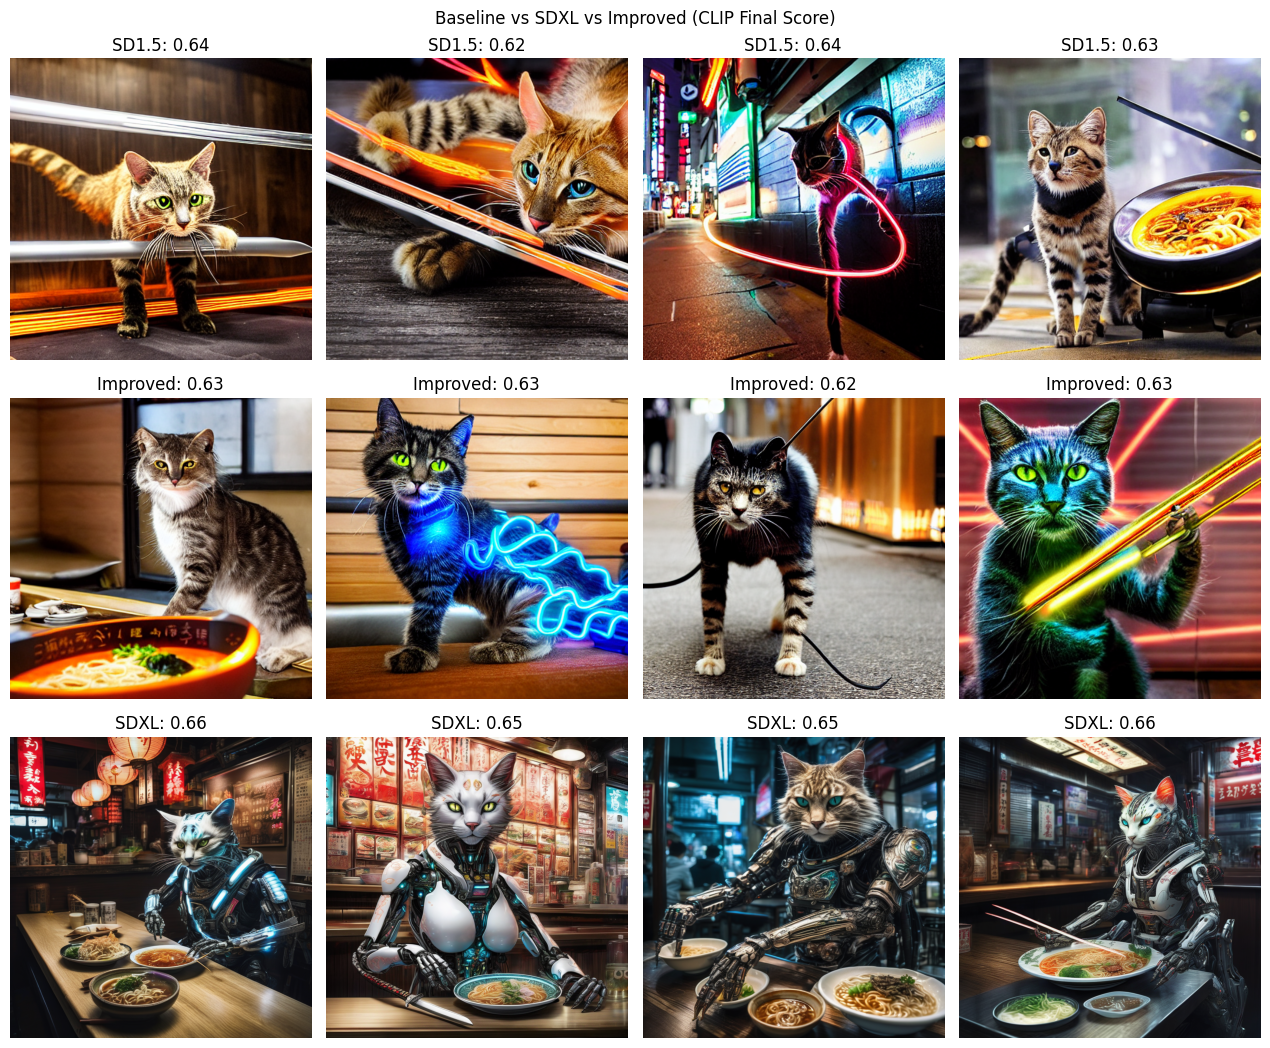

Avg baseline score: 0.628
Avg improved score: 0.63
Avg delta (Improved - baseline): 0.002
Avg SDXL score: 0.657
Avg delta (SDXL - baseline): 0.029


In [53]:
# Baseline vs SDXL vs Improved comparison (images + CLIP scores)
import matplotlib.pyplot as plt
from PIL import Image

if "images" not in globals() or not images:
    raise ValueError("Baseline images not found. Run System B first.")
if "results" not in globals() or not results:
    raise ValueError("Baseline results not found. Run System C first.")
if "sdxl_images" not in globals() or not sdxl_images:
    raise ValueError("SDXL images not found. Run the SDXL comparison cell first.")
if "sdxl_results" not in globals() or not sdxl_results:
    raise ValueError("SDXL results not found. Run the SDXL comparison cell first.")

baseline_imgs = images
baseline_scores = [r.get("scores", {}).get("final_score", None) for r in results]

sdxl_imgs = sdxl_images
sdxl_scores = [r.get("scores", {}).get("final_score", None) for r in sdxl_results]

improved_imgs = refined_images if "refined_images" in globals() else []
improved_scores = [r.get("scores", {}).get("final_score", None) for r in refined_results] if "refined_results" in globals() else []

rows = 2 + (1 if improved_imgs else 0)

n = min(5, len(baseline_imgs), len(sdxl_imgs))
if improved_imgs:
    n = min(n, len(improved_imgs))

fig, axes = plt.subplots(rows, n, figsize=(3.2 * n, 3.6 * rows))
if n == 1:
    axes = [axes]

for i in range(n):
    img = Image.open(baseline_imgs[i]).convert("RGB")
    ax = axes[0][i]
    ax.imshow(img)
    score = baseline_scores[i]
    ax.set_title(f"SD1.5: {score:.2f}" if score is not None else "SD1.5")
    ax.axis("off")

if improved_imgs:
    for i in range(n):
        img = Image.open(improved_imgs[i]).convert("RGB")
        ax = axes[1][i]
        ax.imshow(img)
        score = improved_scores[i]
        ax.set_title(f"Improved: {score:.2f}" if score is not None else "Improved")
        ax.axis("off")

for i in range(n):
    img = Image.open(sdxl_imgs[i]).convert("RGB")
    ax = axes[2 if improved_imgs else 1][i]
    ax.imshow(img)
    score = sdxl_scores[i]
    ax.set_title(f"SDXL: {score:.2f}" if score is not None else "SDXL")
    ax.axis("off")

plt.suptitle("Baseline vs SDXL vs Improved (CLIP Final Score)")
plt.tight_layout()
plt.show()

avg_base = sum(s for s in baseline_scores if s is not None) / max(1, sum(s is not None for s in baseline_scores))
avg_sdxl = sum(s for s in sdxl_scores if s is not None) / max(1, sum(s is not None for s in sdxl_scores))
print("Avg baseline score:", round(avg_base, 3))
if improved_scores:
    avg_improved = sum(s for s in improved_scores if s is not None) / max(1, sum(s is not None for s in improved_scores))
    print("Avg improved score:", round(avg_improved, 3))
    print("Avg delta (Improved - baseline):", round(avg_improved - avg_base, 3))
print("Avg SDXL score:", round(avg_sdxl, 3))
print("Avg delta (SDXL - baseline):", round(avg_sdxl - avg_base, 3))